In [1]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=8, stride=stride, padding='same', bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.conv_downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride,padding='same', bias=False)
        self.bn_downsample = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.stride != 1 or residual.shape[1] != out.shape[1]:
            residual = self.conv_downsample(residual)
            residual = self.bn_downsample(residual)
        
        out += residual
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes, block_sizes=[64, 128, 256, 512], num_blocks=[2, 2, 2, 2]):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, block_sizes[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(block_sizes[0])
        self.layer1 = self._make_layer(block_sizes[0], block_sizes[1], num_blocks[0])
        self.layer2 = self._make_layer(block_sizes[1], block_sizes[2], num_blocks[1])
        # self.layer3 = self._make_layer(block_sizes[2], block_sizes[3], num_blocks[2])
        # self.layer4 = self._make_layer(block_sizes[3], block_sizes[3], num_blocks[3])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(block_sizes[2], num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels))
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
import torch

from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


model = ResNet(in_channels=1, num_classes=3).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device = 'cuda'
data_dir = 'w9_bilstm_small'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=4,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Params:  1930883


  0%|          | 0/4741 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
 21%|██        | 992/4741 [04:23<16:36,  3.76it/s]


KeyboardInterrupt: 

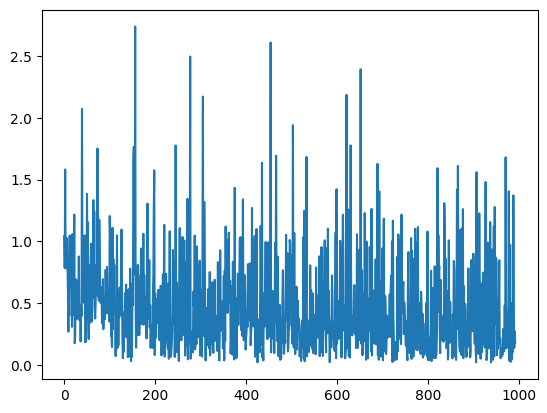

In [2]:

lossi = []
model.train()
for i in range(5):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr.view(-1,1,45000))
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        plt.plot(lossi)
        plt.savefig('loss.jpg')
        plt.close()